# Notebook for Collecting Samples from Kitchen Data

### Run each cell in order, starting with the import below.

Troubleshooting import errors in Jupyter Notebook can be done using this guide:
https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/


In [2]:
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import stats, signal
import random
from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools
import pyaudio
import wave
import os
import sys
import struct
import math


from sys import byteorder
from array import array
from struct import pack
from scipy.io.wavfile import read

In [11]:
# Defining a few helper functions
# No output expected from this cell!


# Code adapted from PlayingWithSignals.ipynb,
# Created by Dr. Jon Froehlich for CSE599H at the University of Washington during Spring 2019
def plot_signal_to_axes(ax, s, sampling_rate, title="", signal_label=None):
    ax.plot(s, label=signal_label)
    ax.set(xlabel="samples")
    
    if signal_label is not None:
        ax.legend()

    # we use y=1.14 to make room for the secondary x-axis
    # see: https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
    ax.set_title(title, y=1.2)
    ax.grid()

    # add in a secondary x-axis to draw the x ticks as time (rather than samples)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("time (secs)")
    ax_ticks = ax.get_xticks()[1:-1]
    ax2_tick_labels = ax.get_xticks()[1:-1] / sampling_rate
    ax2_tick_labels = ['{:.2f}s'.format(x) for x in ax2_tick_labels]
    ax2.set_xticks(ax_ticks)
    ax2.set_xticklabels(ax2_tick_labels)

# Noise gate for detecting sound event taken from: 
# https://stackoverflow.com/questions/18406570/python-record-audio-on-detected-sound

def rms(frame):
    count = len(frame)/swidth
    format = "%dh"%(count)
    # short is 16 bit int
    shorts = struct.unpack( format, frame )
    sum_squares = 0.0
    for sample in shorts:
        n = sample * SHORT_NORMALIZE
        sum_squares += n*n
    # compute the rms 
    rms = math.pow(sum_squares/count,0.5);
    return rms * 1000


def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return rms(snd_data) < THRESHOLD


# open port and listen
# when over threshold, begin to store
# when stops, segment and send
def record():
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False
    r = array('h')
    
    print("listening")
    count = -1
    while 1:
        count += 1
        # little endian, signed short
        frame = stream.read(CHUNK_SIZE)
        snd_data = array('h', frame)
        if byteorder == 'big':
            snd_data.byteswap()
        
        r.extend(snd_data)
        #snd_started = is_above_threshold(snd_data)
        
        activity_check = rms(frame)
        #print("activity: {}".format(activity_check))
        silent = is_silent(frame)
        
        #print("loudness: {}".format(max(snd_data)))
        
        if count <= 10:
            continue
        
        if silent and not snd_started:
            
            continue
            
        #r.extend(snd_data)
        
        if silent and snd_started:
            num_silent += 1
            print("silent: {}".format(num_silent))
        elif not silent and snd_started:
            num_silent = 0
        elif not silent and not snd_started:
            print("recording")
            snd_started = True
            startNum = count
            
        # captured a sample
        if snd_started and num_silent > 30:
            
            # captured
            if len(r[(startNum*CHUNK_SIZE):]) > 44100:
                print("stop: silent too long")
                break
                #sample = LiveSound(r, RATE)
                #print(trained_model.classifySample(sample))
                
            else:
                print("too short: ",len(r[startNum:]))
                
            num_silent = 0
            r = array('h')
            snd_started = False
           
            print("listening")

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    print("close")
    p.terminate()

    return sample_width, r[((startNum-10)*CHUNK_SIZE):(-20*CHUNK_SIZE)]

def record_to_file(filename):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    path = os.path.join(SAMPLES_LOCATION, filename)
    
    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
    
##### Code for iterating over data collection
#map sound name to its number  data so far and it's shortcut
class Sound:
    def __init__(self, name, shortcut, count=0):
        self.name = name
        self.shortcut = shortcut
        self.count = 0

    
def capture_audio():
    while 1:
        prompt = "What sound?\n"
        for sound in SOUND_LABELS.values():
            prompt += sound.shortcut + ": " + sound.name +"\n"
        prompt += "x: Exit\n"
        soundNameID = input(prompt)
        if soundNameID == "x":
            return
        outfile = SOUND_LABELS[soundNameID].name+"_"+str(SOUND_LABELS[soundNameID].count)+"_captured.wav"
        SOUND_LABELS[soundNameID].count += 1
        record_to_file(outfile)
        print("saved to: "+outfile)

# Sample Recording

### Change the sound labels and save location 
Labels should be changed to the targeted sounds in your kitchen. 
Make sure the shortcut at the beginning matches each shortcut at the end.

In [ ]:
SAMPLES_LOCATION = "/Users/xxxx/Documents/KitchenSoundClassifier/MySamples/NewDir"

SOUND_LABELS = {
        'me':Sound("MicrowaveEnding","me"),
        'mo':Sound("MicrowaveDoorOpen","mo"),
        'mc':Sound("MicrowaveDoorClose","mc"),
          
        'amb':Sound("Ambient","amb"),
          
        's':Sound("Silverware","s"),
        'b':Sound("Boiling","b"),
        't':Sound("Toaster","t"),
        'f':Sound("Faucet","f"),
        'o':Sound("OvenTimer","o"),
        'g':Sound("GarbageDisposal","g"),
        'i':Sound("InstantPotBeep","i"),
        'fro':Sound("FridgeDoorOpen","fro"),
        'frc':Sound("FridgeDoorClose","frc")}


######
## Structure of audio capture code from: https://stackoverflow.com/questions/892199/detect-record-audio-in-python
THRESHOLD = 30
CHUNK_SIZE = 1024*4
FORMAT = pyaudio.paInt16
RATE = 44100
swidth = 2
SHORT_NORMALIZE = (1.0/32768.0)

    
if __name__ == '__main__':
    prompt = "What sound: "
    
    #for sound in Sound
    #    prompt += str(sound)
    #    print(sound)
    capture_audio()

### Quick Sound Visualization

To check what you captured, input the relative location of the output WAV file below and run the cell.

[Audacity](https://www.audacityteam.org/) can also be used to quickly check/edit WAV files.

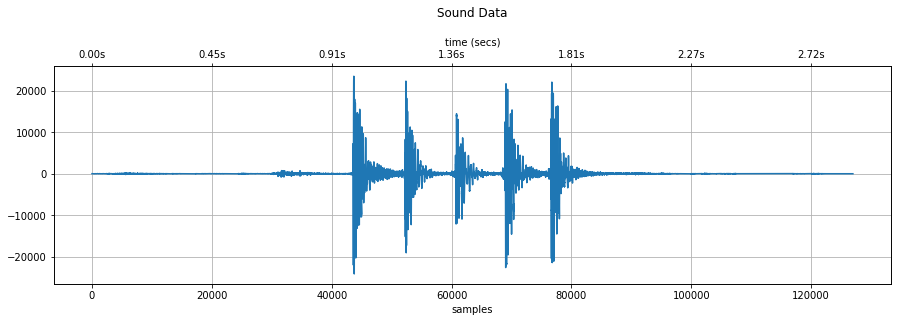

In [12]:
FILE_FOR_VIS = "Silverware_0_captured.wav"



a = read(FILE_FOR_VIS)
sound_data = np.array(a[1],dtype=float)
sampling_rate = a[0]

fig, ax = plt.subplots(figsize=(15,4)) #figsize is width, height

plot_signal_to_axes(ax, sound_data, sampling_rate, 'Sound Data')